In this notebook, we will demonstrate the difference between using sigmoid and ReLU nonlinearities in a simple neural network with two hidden layers.

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Generate Data


Lets generate a classification dataset that is spiral and not easily linearly separable. It consists of three classes : blue , red and yellow

(-1.0, 1.0)

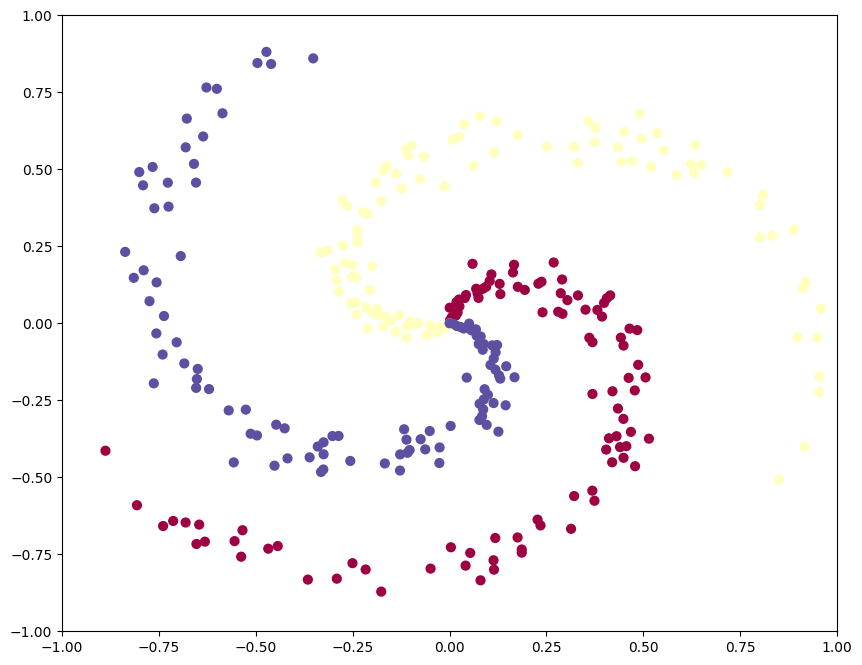

In [2]:
#generate random data -- not linearly separable
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
num_train_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

# Activation Functions

The sigmoid function "squashes" inputs to lie between 0 and 1. Unfortunately, this means that for inputs with sigmoid output close to 0 or 1, the gradient with respect to those inputs are close to zero. This leads to the phenomenon of vanishing gradients, where gradients drop close to zero, and the net does not learn well.

On the other hand, the relu function (max(0, x)) does not saturate with input size. Plot these functions to gain intution.

In [3]:
def sigmoid(x):
### TODO: START CODE HERE ###
## implemenmt the sigmoid activation here
     x = 1 /(1+np.exp(-x))
     return x
### END CODE HERE ###

def sigmoid_grad(x):
### TODO: START CODE HERE ###
     return x * (1-x)
## implement gradient of the sigmoid activation here

### END CODE HERE ###

def relu(x):
### TODO: START CODE HERE ###
## implement the relu activation here
    return np.maximum(0,x)
### END CODE HERE ###

# Neural Network


Let's try and see now how the two kinds of nonlinearities change deep neural net training in practice. Below, we build a very simple neural net with three layers (two hidden layers), for which you can swap out ReLU/ sigmoid nonlinearities.

In [4]:
#function to train a three layer neural net with either RELU or sigmoid nonlinearity via vanilla grad descent
def three_layer_net(NONLINEARITY,X,y, model, step_size, reg):
    #parameter initialization

    h= model['h']
    h2= model['h2']
    W1= model['W1']
    W2= model['W2']
    W3= model['W3']
    b1= model['b1']
    b2= model['b2']
    b3= model['b3']


    # gradient descent loop
    num_examples = X.shape[0]
    plot_array_1=[]
    plot_array_2=[]
    for i in range(50000):

        # TODO: START YOUR CODE HERE
        # Implement FOWARD PROP here
        if NONLINEARITY== 'RELU':
            hidden_layer = relu(np.matmul(X ,W1) + b1)
            hidden_layer2 = relu(np.matmul(hidden_layer, W2) + b2)
            scores = relu(np.matmul(hidden_layer2, W3) + b3)

        elif NONLINEARITY == 'SIGM':
            hidden_layer = sigmoid(np.matmul(X,W1) + b1)
            hidden_layer2 = sigmoid(np.matmul(hidden_layer, W2) + b2)
            scores = (np.matmul(hidden_layer2, W3) + b3)
        #END YOUR CODE HERE

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)+ 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i % 1000 == 0:
            print ("iteration %d: loss %f" % (i, loss))


        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples


        # BACKPROP HERE
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)


        if NONLINEARITY == 'RELU':

            #backprop ReLU nonlinearity here
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 =  np.dot( hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0

        elif NONLINEARITY == 'SIGM':

            #TODO: backprop sigmoid nonlinearity here
            #START YOUR CODE HERE
            dhidden2 = np.dot(dscores, W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = np.dot(hidden_layer.T, dhidden2)
            #END YOUR CODE HERE
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer)


        dW1 =  np.dot(X.T, dhidden)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden, axis=0)

        # add regularization
        dW3+= reg * W3
        dW2 += reg * W2
        dW1 += reg * W1

        #option to return loss, grads -- uncomment next comment
        grads={}
        grads['W1']=dW1
        grads['W2']=dW2
        grads['W3']=dW3
        grads['b1']=db1
        grads['b2']=db2
        grads['b3']=db3
        #return loss, grads


        # update
        W1 += -step_size * dW1
        b1 += -step_size * db1
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
    # evaluate training set accuracy
    if NONLINEARITY == 'RELU':
        hidden_layer = relu(np.dot(X, W1) + b1)
        hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)
    elif NONLINEARITY == 'SIGM':
        hidden_layer = sigmoid(np.dot(X, W1) + b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)
    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    print ('training accuracy: %.2f' % (np.mean(predicted_class == y)) )
    #return cost, grads
    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3


# Training

In [5]:
#Initialize model, train sigmoid network first

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
h=50
h2=50
num_train_examples = X.shape[0]

model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(sigm_array_1, sigm_array_2, s_W1, s_W2,s_W3, s_b1, s_b2,s_b3) = three_layer_net('SIGM', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.156405
iteration 1000: loss 1.100737
iteration 2000: loss 0.999698
iteration 3000: loss 0.855495
iteration 4000: loss 0.819427
iteration 5000: loss 0.814825
iteration 6000: loss 0.810526
iteration 7000: loss 0.805943
iteration 8000: loss 0.800688
iteration 9000: loss 0.793976
iteration 10000: loss 0.783201
iteration 11000: loss 0.759909
iteration 12000: loss 0.719792
iteration 13000: loss 0.683194
iteration 14000: loss 0.655847
iteration 15000: loss 0.634996
iteration 16000: loss 0.618527
iteration 17000: loss 0.602246
iteration 18000: loss 0.579710
iteration 19000: loss 0.546264
iteration 20000: loss 0.512831
iteration 21000: loss 0.492403
iteration 22000: loss 0.481854
iteration 23000: loss 0.475923
iteration 24000: loss 0.472031
iteration 25000: loss 0.469086
iteration 26000: loss 0.466611
iteration 27000: loss 0.464386
iteration 28000: loss 0.462306
iteration 29000: loss 0.460319
iteration 30000: loss 0.458398
iteration 31000: loss 0.456528
iteration 32000: loss

Training accuracy for sigmoid should be 0.96 and for RELU it is 0.99.

In [6]:
#Re-initialize model, train relu network

model={}
model['h'] = h # size of hidden layer 1
model['h2']= h2# size of hidden layer 2
model['W1']= 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2']= np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(relu_array_1, relu_array_2, r_W1, r_W2,r_W3, r_b1, r_b2,r_b3) = three_layer_net('RELU', X,y,model, step_size=1e-1, reg=1e-3)

iteration 0: loss 1.113916
iteration 1000: loss 0.234275
iteration 2000: loss 0.159512
iteration 3000: loss 0.149298
iteration 4000: loss 0.145775
iteration 5000: loss 0.143763
iteration 6000: loss 0.142191
iteration 7000: loss 0.140962
iteration 8000: loss 0.139982
iteration 9000: loss 0.139176
iteration 10000: loss 0.138516
iteration 11000: loss 0.137978
iteration 12000: loss 0.137550
iteration 13000: loss 0.137203
iteration 14000: loss 0.136906
iteration 15000: loss 0.136655
iteration 16000: loss 0.136459
iteration 17000: loss 0.136284
iteration 18000: loss 0.136118
iteration 19000: loss 0.135987
iteration 20000: loss 0.135866
iteration 21000: loss 0.135764
iteration 22000: loss 0.135677
iteration 23000: loss 0.135587
iteration 24000: loss 0.135507
iteration 25000: loss 0.135431
iteration 26000: loss 0.135353
iteration 27000: loss 0.135291
iteration 28000: loss 0.135224
iteration 29000: loss 0.135151
iteration 30000: loss 0.135093
iteration 31000: loss 0.135038
iteration 32000: loss

# The Vanishing Gradient Issue


We can use the sum of the magnitude of gradients for the weights between hidden layers as a cheap heuristic to measure speed of learning (you can also use the magnitude of gradients for each neuron in the hidden layer here). Intuitevely, when the magnitude of the gradients of the weight vectors or of each neuron are large, the net is learning faster.

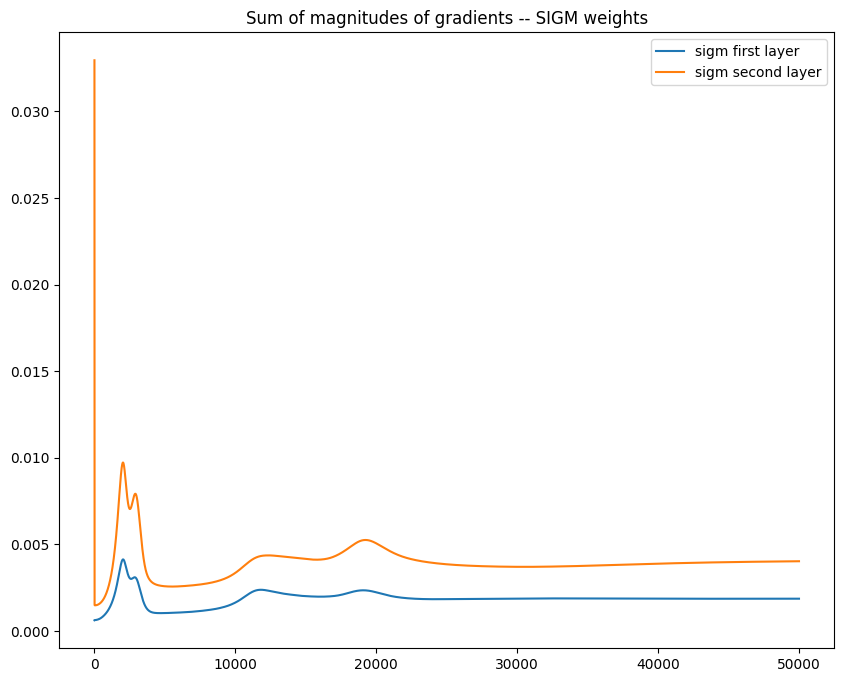

In [7]:
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(("sigm first layer", "sigm second layer"))

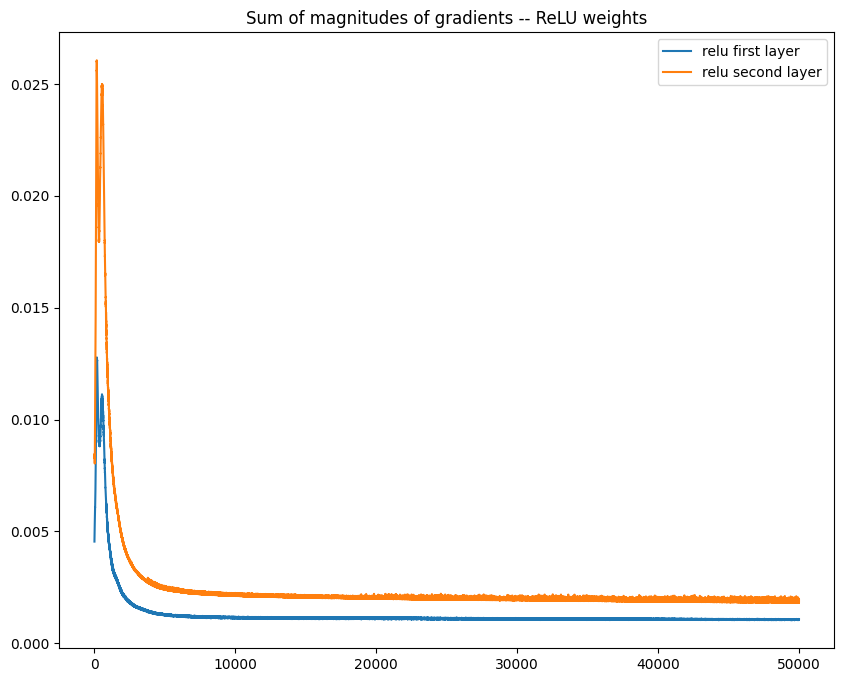

In [8]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- ReLU weights')
plt.legend(("relu first layer", "relu second layer"))

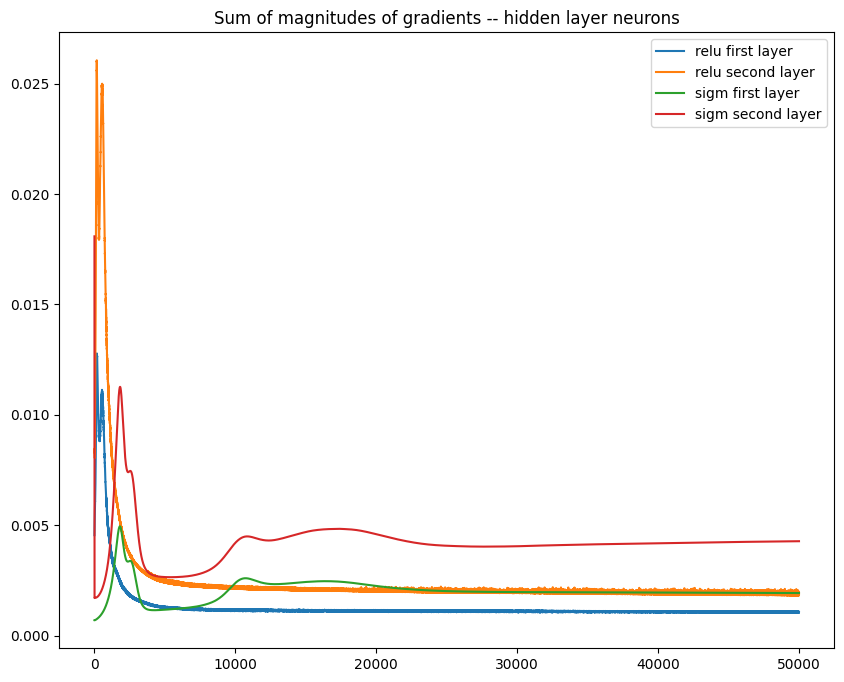

In [ ]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- hidden layer neurons')
plt.legend(("relu first layer", "relu second layer","sigm first layer", "sigm second layer"))

# Plot the classifiers

(-1.8712034092398278, 1.8687965907601756)

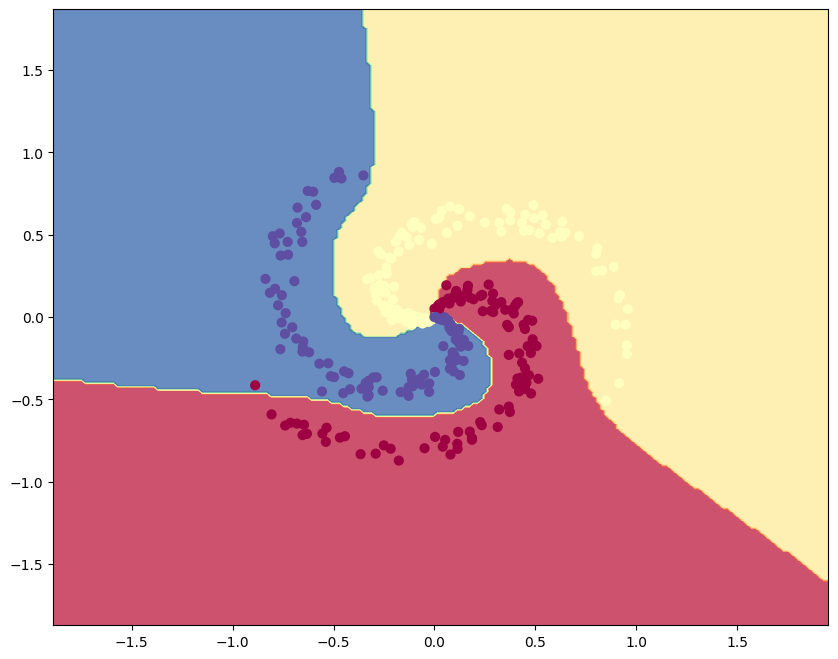

In [9]:
# plot the classifiers- SIGMOID
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(sigmoid(np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], s_W1) + s_b1), s_W2) + s_b2), s_W3) + s_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.8712034092398278, 1.8687965907601756)

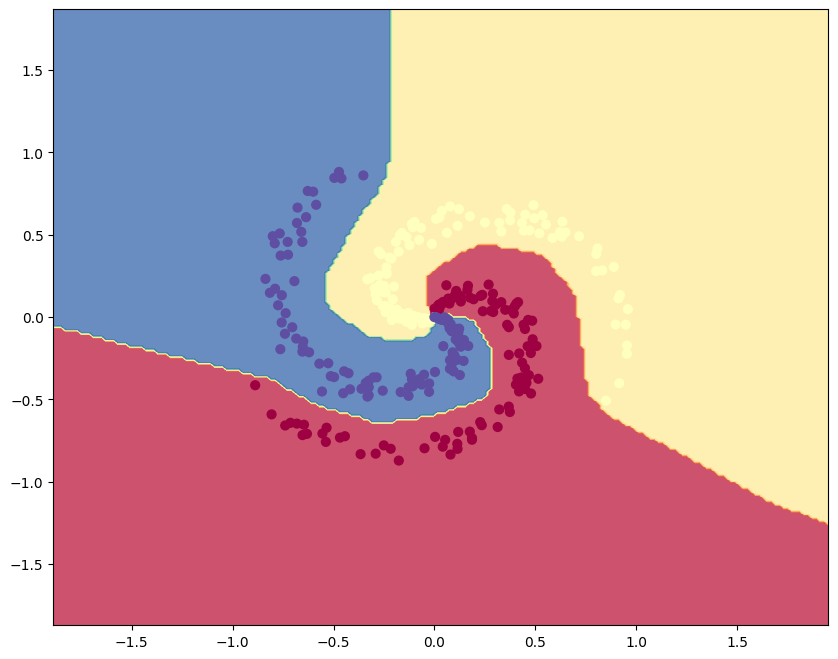

In [10]:
# plot the classifiers-- RELU
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(relu(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], r_W1) + r_b1), r_W2) + r_b2), r_W3) + r_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())